In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

MEMORY = 8*1024

gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.set_logical_device_configuration(gpus[0],
                                              [tf.config.LogicalDeviceConfiguration(memory_limit=MEMORY)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
except RuntimeError as e:        
    # Memory growth must be set before GPUs have been initialized
    print(e) 
    
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")
from turing.utils import *
from turing.tf_utils import *
import turing.pinns as tu
from turing.loss_functions import *

2023-02-15 01:40:01.050752: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-15 01:40:01.267684: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-15 01:40:02.001491: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /end/home/rh2310/lib:/end/soft/Linux_2.6_64/lib::/end/home/rh2310/.conda/envs/tensorflo

1 Physical GPUs, 1 Logical GPUs


In [2]:
from local_utils import *

# Note to remember
# In this form of reshaping the datasets, u, u_xx, u_yy, u_t, v, v_xx and v_yy, v_t must be transposed to correctly show x and y coordinates

# This note book use only one snapshot (the last), does not estimate the time derivatives and use the exact u and v to reduce the loss residual. FInaly, the parameters are constant.

In [3]:
sim_name = "Koch_Meinhardt_7"
x_slice=slice(0,100,1)#slice(30,65,1)#slice(0,100,1)#slice(30,65,1)#slice(50,65,1)#
y_slice=slice(0,100,1)#slice(50,85,1)#slice(0,100,1)#slice(50,85,1)#slice(70,85,1)#
pattern = load(sim_name, x_slice, y_slice,
               data_time_start=-3,
               data_time_len=2,
               data_time_step=1)

x_range = np.linspace(0, 1, pattern.simulation.n[0])*pattern.simulation.L[0]
y_range = np.linspace(0, 1, pattern.simulation.n[0])*pattern.simulation.L[1]
x_range = x_range[x_slice]
y_range = y_range[y_slice]

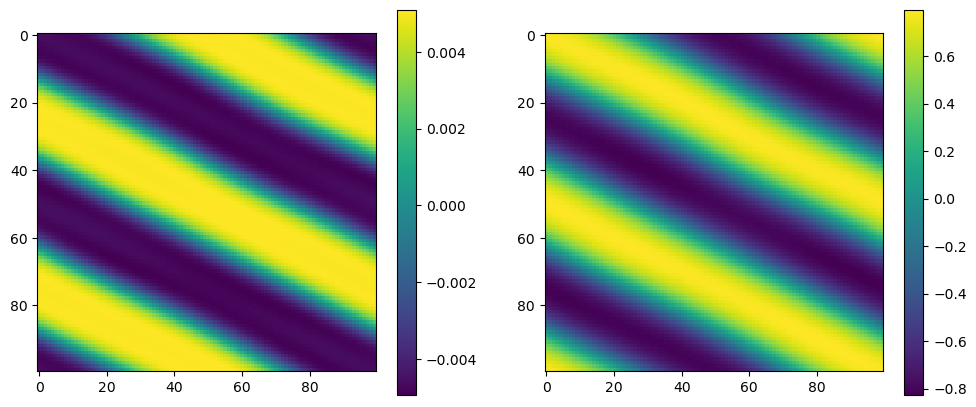

In [4]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.imshow(pattern.params["D_u"]*(pattern.c_xx[0,:, : , -1] + pattern.c_yy[0,:, : , -1]) - pattern.c_t[0,:, : , -1])
plt.colorbar()
plt.subplot(122)
plt.imshow(pattern.params["D_v"]*(pattern.c_xx[1,:, : , -1] + pattern.c_yy[1,:, : , -1]) - pattern.c_t[1,:, : , -1])
plt.colorbar()

In [5]:
x = tf.constant(x_range, dtype=tf.float32)
y = tf.constant(y_range, dtype=tf.float32)
# The order of the Y and X must be reversed,
# since the chnages the value finds the derivatives
#Y, X = tf.meshgrid(x, y)
X, Y = tf.meshgrid(x, y)
ts = tf.constant(pattern.t_star[-1:], dtype=tf.float32)
T = ts[tf.newaxis, tf.newaxis, :] * tf.ones(X.shape)[:, :, tf.newaxis]
H = tf.concat(
            [
                tf.concat(
                    [
                        X[tf.newaxis, :, :, tf.newaxis],
                        Y[tf.newaxis, :, :, tf.newaxis],
                        T[:, :, i : i + 1][tf.newaxis, :, :, :],
                    ],
                    axis=3,
                )
                for i in range(T.shape[-1])
            ],
            axis=0,
        )

In [6]:
H.shape

TensorShape([1, 100, 100, 3])

In [7]:
def grads(pinn, inputs):
    
    with tf.GradientTape(persistent=True) as tape:        
        tape.watch(inputs)      
        
        with tf.GradientTape(persistent=True) as tape2:             
            tape2.watch(inputs)            
            outputs = pinn.net(inputs)            
        
            u = tf.squeeze(outputs[:, 0])
            v = tf.squeeze(outputs[:, 1])
            
            grad_u = tape2.gradient(u, inputs)
            u_x = grad_u[:, 0]
            u_y = grad_u[:, 1]
            u_t = grad_u[:, 2]
            
            grad_v = tape2.gradient(v, inputs)
            v_x = grad_v[:, 0]
            v_y = grad_v[:, 1]
            v_t = grad_v[:, 2]
                    
        grad_u_x = tape.gradient(u_x, inputs)
        u_xx = grad_u_x[:, 0]
        #u_yx = grad_u_x[:, :, :, 1]
        #u_tx = grad_u_x[:, :, :, 2]
        grad_u_y = tape.gradient(u_y, inputs)
        #u_xy = grad_u_y[:, :, :, 0]
        u_yy = grad_u_y[:, 1]
        #u_ty = grad_u_y[:, :, :, 2]
        grad_v_x = tape.gradient(v_x, inputs)
        v_xx = grad_v_x[:, 0]
        #v_yx = grad_v_x[:, :, :, 1]
        #v_tx = grad_v_x[:, :, :, 2]
        grad_v_y = tape.gradient(v_y, inputs)
        #v_xy = grad_v_y[:, :, :, 0]
        v_yy = grad_v_y[:, 1]
        #v_ty = grad_v_y[:, :, :, 2]
                                     
    return (tf.squeeze(u),
            tf.squeeze(u_xx), tf.squeeze(u_yy), tf.squeeze(u_t),
            tf.squeeze(v),
            tf.squeeze(v_xx), tf.squeeze(v_yy), tf.squeeze(v_t))


In [8]:
class NN2(tu.NN):
    def build(self):
        """Create the state of the layers (weights)"""
        self.weights = []
        self.scales = []
        self.biases = []
        for i in range(0, self.num_layers - 1):
            W = self.xavier_init(size=[self.layers[i], self.layers[i + 1]])
            a = tf.Variable(tf.ones([1, self.layers[i + 1]], dtype=self.dtype), dtype=self.dtype)
            b = tf.Variable(tf.zeros([1, self.layers[i + 1]], dtype=self.dtype), dtype=self.dtype)
            self.weights.append(W)
            self.scales.append(a)
            self.biases.append(b)
        
        
    @tf.function
    def net(self, inputs):
        # Map the inputs to the range [-1, 1]
        H = 2.0 * (inputs - self.lb) / (self.ub - self.lb) - 1.0
        for W, a ,b in zip(self.weights, self.scales, self.biases):
            outputs = tf.matmul(H, W)
            outputs = a*outputs + b
            H = tf.tanh(outputs)
        return outputs

### - $\frac{\partial u^*}{\partial t^*} =  (\partial_{x^* x^*} + \partial_{y^* y^*}) u^*
 + \rho^*_u \frac{(u^*)^2 v^*}{1 + \kappa_u (u^*)^2} - u^* + 1$
### - $\frac{\partial v^*}{\partial t^*} =  D (\partial_{x^* x^*} + \partial_{y^* y^*}) v^*
 - \rho^*_v \frac{(u^*)^2 v^*}{1 + \kappa_u^* (u^*)^2} + 1$

### - $  u = (\sigma_u/\mu_u) u^*$
### - $  v = (\sigma_v/\mu_u) v^*$
### - $  t = t^*/ \mu_u$
### - $  x = \sqrt{\frac{D_u}{\mu_u}} x^*$
### - $  y = \sqrt{\frac{D_u}{\mu_u}} y^*$
### - $  D = \frac{D_v}{D_u}$
### - $  \rho_u = (\frac{\mu_u^3}{\sigma_u \sigma_v}) \rho^*_u$
### - $  \rho_v = (\frac{\mu_u^3}{\sigma_u^2}) \rho^*_v$
### - $  \kappa_u = (\frac{\mu_u^2}{\sigma_u^2}) \kappa_u^*$

In [9]:
def simulate(i, init_D_per, init_rho_u_per, init_rho_v_per, init_kappa_u_per, init_kappa_u_bias):
    lb = tf.constant([x_range[0], y_range[0], pattern.t_star[0]], dtype=tf.float32)
    ub =  tf.constant([x_range[-1], y_range[-1], pattern.t_star[-1]], dtype=tf.float32)
    pinn = NN2([3, 128, 128, 2], lb, ub, tf.float32)
    optimizer=keras.optimizers.Adam(learning_rate=1e-2)

    spatial_fac = np.sqrt(pattern.params["mu_u"]/pattern.params["D_u"])
    time_fac = pattern.params["mu_u"]
    u_fac = pattern.params["mu_u"]/pattern.params["sigma_u"]
    v_fac = pattern.params["mu_u"]/pattern.params["sigma_v"]
    
    # Data is a three column matrix as (x,y,t), where
    # first x changes, then y, and finally t (like Boolean tables)
    data = tf.reshape(H, (H.shape[0]*H.shape[1]*H.shape[2],3))

    # transformation
    data = data * tf.constant([spatial_fac, spatial_fac, time_fac], dtype=pinn.dtype)
    
    #Select the last time step
    # and reorder the x and y to match it
    # with H
    c_copy = np.einsum("cxy -> cyx", pattern.c[..., -1].copy())
    #reshape c to flatten the data for each species
    c = c_copy.reshape((2, pattern.c.shape[1]*pattern.c.shape[2]))
    # and finnaly use its transposed, to have the each speacices in on column 
    c = c.T

    # transformation
    c = c * np.array([u_fac, v_fac])
    def gen_series():    

        for i in range(data.shape[0]):
            h = data[i,:]
            yield h, c[i,:]    

    ds = tf.data.Dataset.from_generator(gen_series,
                                        output_types=(tf.float32, tf.float32), 
                                        output_shapes=((3,),(2,)))

    def clip_by_value_zero_lb(z):
        return tf.clip_by_value(z, 1e-6, 1e10,)

    init_per = 4.0
    D_val = (pattern.params["D_v"]/pattern.params["D_u"])*init_D_per
    D = tf.Variable(D_val,
                    pinn.dtype,
                    name="D",
                    constraint=clip_by_value_zero_lb)

    rho_u_val = ((pattern.params["mu_u"]**3)/(pattern.params["sigma_u"]*pattern.params["sigma_v"])
                  )*pattern.params["rho_u"]*init_rho_u_per
    rho_u = tf.Variable(rho_u_val,
                        pinn.dtype,
                        name="rho_u",
                        constraint=clip_by_value_zero_lb)

    rho_v_val = ((pattern.params["mu_u"]**3)/(pattern.params["sigma_u"]**2)
                 )*pattern.params["rho_v"]*init_rho_v_per
    rho_v = tf.Variable(rho_v_val,
                        pinn.dtype,
                        name="rho_v",
                        constraint=clip_by_value_zero_lb)

    kappa_u_val = ((pattern.params["mu_u"]**2)/(pattern.params["sigma_u"]**2)
                   )*pattern.params["kappa_u"]*init_kappa_u_per + init_kappa_u_bias
    kappa_u = tf.Variable(kappa_u_val,
                          pinn.dtype,
                          name="kappa_u",
                          constraint=clip_by_value_zero_lb)


    params = (D_val, rho_u_val, rho_v_val, kappa_u_val)
    print("D: ", D_val)
    print("rho_u: ", rho_u_val)
    print("rho_v: ", rho_v_val) 
    print("kappa_u: ", kappa_u_val)

    @tf.function
    def train_step_inverse(elements):
        with tf.GradientTape(persistent=True) as tape: 
            H = elements[0]
            tape.watch(H)
            trainables = pinn.trainable_variables #+ params_tf


            with tf.GradientTape(persistent=True) as tape2:             
                tape2.watch(H)

                outputs = pinn.net(H)
                ug = tf.squeeze(outputs[:, 0])
                vg = tf.squeeze(outputs[:, 1])

                grad_u = tape2.gradient(ug, H)
                u_x = grad_u[:, 0]
                u_y = grad_u[:, 1]

                grad_v = tape2.gradient(vg, H)
                v_x = grad_v[:, 0]
                v_y = grad_v[:, 1]

            grad_u_x = tape.gradient(u_x, H)
            u_xx = grad_u_x[:, 0]
            grad_u_y = tape.gradient(u_y, H)
            u_yy = grad_u_y[:, 1]
            grad_v_x = tape.gradient(v_x, H)
            v_xx = grad_v_x[:, 0]
            grad_v_y = tape.gradient(v_y, H)
            v_yy = grad_v_y[:, 1]

            u = tf.squeeze(elements[1][:, 0])
            v = tf.squeeze(elements[1][:, 1])
            f = u * u * v / (1.0 + kappa_u * u * u)
            f_u =(u_xx + u_yy) + rho_u * f - u + 1# - u_t
            f_v = D * (v_xx + v_yy) - rho_v * f + 1# - v_t
            l2_res_u = tf.reduce_sum(f_u**2)
            l2_res_v = tf.reduce_sum(f_v**2)

            l2 = l2_res_u + l2_res_v

        grads = tape.gradient(l2, trainables)
        optimizer.apply_gradients(zip(grads, trainables))
        return (l2_res_u, l2_res_v)
    
    batch_size = 5000
    def print_callback(printer, losses, epoch):
        printer(f"at epoch {epoch:d}\n"
                f" total loss: {np.sum(losses)}"
                f"  u: {losses[0]},  v: {losses[1]},\n"
               # f" Res u: {losses[1]}, Res v: {losses[2]},\n"
               )
        printer(f"D: {D.numpy()} \n" 
                 f"rho_u: {rho_u.numpy()}, rho_v: {rho_v.numpy()} \n"                 
                 f"kappa_u: {kappa_u.numpy()} \n") 

    losses = tu.train(epochs=20000+1,
                      batch_size=batch_size,
                      dataset = ds ,
                      train_step = train_step_inverse,
                      train_step_returns_num = 2,
                      print_interval=1000,
                      loss_sample_interval = 1,
                      stop_threshold=1e-5,
                      print_callback = print_callback,
                      epoch_callback=None)
    print("minimum loss: ", np.min(np.sum(losses, axis=1)))
    
    plt.plot(losses[:,0])
    plt.plot(losses[:,1])
    plt.yscale('log')
    plt.show()
    (u, u_xx, u_yy, u_t, v, v_xx, v_yy, v_t) = grads(pinn, data)
    def to(arr):
        return arr.numpy().reshape(y_range.shape[0], x_range.shape[0])

    actual_u_der = pattern.params["D_u"]*(pattern.c_xx[0,:, : , -1] + pattern.c_yy[0,:, : , -1]) - pattern.c_t[0,:, : , -1]
    actual_v_der = pattern.params["D_v"]*(pattern.c_xx[1,:, : , -1] + pattern.c_yy[1,:, : , -1]) - pattern.c_t[1,:, : , -1]

    u_der = pattern.params["D_u"]*( to(u_xx) + to(u_yy))# - to(u_t2)[-1, ...]
    v_der = pattern.params["D_v"]*( to(v_xx)+ to(v_yy))# - to(v_t2)[-1, ...]
    # X and Y are misoriented
    u_der = u_der.T
    v_der = v_der.T

    u = pattern.c[0,:, : , -1]
    v = pattern.c[1,:, : , -1]
    f = u * u * v / (1.0 + kappa_u * u * u)
    f_u =  rho_u * f - u + 1
    f_v =  - rho_v * f + 1
    
    plt.figure(figsize=(12, 8))
    plt.subplot(341)
    plt.imshow(to(u_xx).T)
    plt.colorbar()
    plt.subplot(342)
    plt.imshow(pattern.c_xx[0,:, : , -1])
    plt.colorbar()
    plt.subplot(343)
    plt.imshow(to(u_yy).T)
    plt.colorbar()
    plt.subplot(344)
    plt.imshow(pattern.c_yy[0,:, : , -1])
    plt.colorbar()
    plt.subplot(345)
    plt.imshow(to(v_xx).T)
    plt.colorbar()
    plt.subplot(346)
    plt.imshow(pattern.c_xx[1,:, : , -1])
    plt.colorbar()
    plt.subplot(347)
    plt.imshow(to(v_yy).T)
    plt.colorbar()
    plt.subplot(3,4,8)
    plt.imshow(pattern.c_yy[1,:, : , -1])
    plt.colorbar()
    plt.tight_layout()
    plt.subplot(3,4,9)
    plt.imshow(to(u_t))
    plt.colorbar()
    plt.subplot(3,4,10)
    plt.imshow(pattern.c_t[0,:, : , -1])
    plt.colorbar()
    plt.subplot(3,4,11)
    plt.imshow(to(v_t))
    plt.colorbar()
    plt.subplot(3,4,12)
    plt.imshow(pattern.c_t[1,:, : , -1])
    plt.colorbar()
    plt.tight_layout()
    plt.show()


    plt.figure(figsize=(12, 8))
    plt.subplot(221)
    plt.imshow(u_der)
    plt.colorbar()
    plt.subplot(222)
    plt.imshow(actual_u_der)
    plt.colorbar()
    plt.subplot(223)
    plt.imshow(v_der)
    plt.colorbar()
    plt.subplot(224)
    plt.imshow(actual_v_der)
    plt.colorbar()
    plt.tight_layout()
    plt.show()
    pinn.save(".", f"./saved_models/Koch_Meinhardt_7_run_{i}")
    return (pinn, optimizer, losses, params)
    
    

In [10]:
sim_params=[
    {'i':1, 'init_D_per':1.1, 'init_rho_u_per':1.1, 'init_rho_v_per':1.1,
     'init_kappa_u_per':1.1, 'init_kappa_u_bias':0},
    {'i':2, 'init_D_per':1.1, 'init_rho_u_per':1.1, 'init_rho_v_per':1.1,
     'init_kappa_u_per':0, 'init_kappa_u_bias':0.1},
    {'i':3, 'init_D_per':2, 'init_rho_u_per':2, 'init_rho_v_per':2,
     'init_kappa_u_per':2, 'init_kappa_u_bias':0},
    {'i':4, 'init_D_per':2, 'init_rho_u_per':2, 'init_rho_v_per':2,
     'init_kappa_u_per':2, 'init_kappa_u_bias':1},
    {'i':5, 'init_D_per':4, 'init_rho_u_per':4, 'init_rho_v_per':4,
     'init_kappa_u_per':4, 'init_kappa_u_bias':0},
    {'i':6, 'init_D_per':2, 'init_rho_u_per':10, 'init_rho_v_per':10,
     'init_kappa_u_per':4, 'init_kappa_u_bias':0},
    {'i':7, 'init_D_per':2, 'init_rho_u_per':10, 'init_rho_v_per':10,
     'init_kappa_u_per':4, 'init_kappa_u_bias':1},
    {'i':8, 'init_D_per':1, 'init_rho_u_per':10, 'init_rho_v_per':10,
     'init_kappa_u_per':5, 'init_kappa_u_bias':1},
    {'i':9, 'init_D_per':20, 'init_rho_u_per':7, 'init_rho_v_per':22,
     'init_kappa_u_per':1, 'init_kappa_u_bias':0},
    {'i':10, 'init_D_per':20, 'init_rho_u_per':7, 'init_rho_v_per':22,
     'init_kappa_u_per':1, 'init_kappa_u_bias':4},
]

In [11]:
results = []
for params in sim_params:
    print("#"*20)
    print(f"        {params['i']}    ")
    print("#"*20)
    ret = simulate(**params)
    results.append(ret)

####################
        1    
####################


ZeroDivisionError: float division by zero